# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

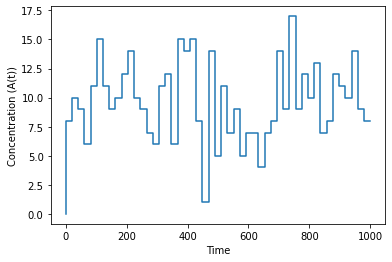

In [2]:
np.random.seed(7)

# Load a forward model
n_0 = 0
model = toy.stochastic.ProductionDegradationModel(n_0)

# Create some toy data
k = [0.1, 1]
times = np.linspace(0, 1000, 50)

values = model.simulate(k, times)
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)
# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0, 0.5], [0.3, 2])
# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('Time')
plt.ylabel('Concentration (A(t))')

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"

my_path = os.path.abspath(__file)


plt.savefig(my_path + '/prod_degr_model.pdf')

# plt.show()

# Calculating the posterior

In [3]:
import math

# Single stationary distribution
def s_stationary(theta, n):
    fct = math.factorial(n)
    frac = theta[1] / theta[0]
    return (frac ** n) * np.exp(-frac) / fct

def p_stationary(theta, data):
    prod = 1.0
    for d in data:
        prod *= s_stationary(theta, d[0])
    return prod

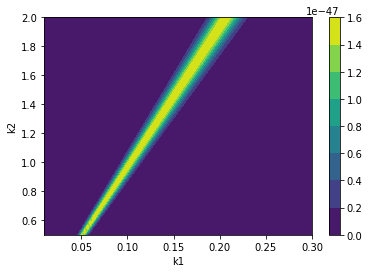

In [4]:
xlist = np.linspace(0.01, 0.3, 100)
ylist = np.linspace(0.5, 2, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = [[p_stationary([x, y], values[10:]) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
# ax.set_title('Contour plot of posterior')

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"

my_path = os.path.abspath(__file)

plt.xlabel("k1")
plt.ylabel("k2")
plt.savefig(my_path + '/prod_degr_posterior.pdf')

# plt.show()

# Compute integral

In [5]:
from scipy import integrate

def f(x, y):
    return p_stationary([x, y], values[10:])

def bounds_x(y):
    return [0.0, 0.3]

def bounds_y():
    return [0.5, 2]

res = integrate.nquad(f, [bounds_x, bounds_y])

print("integral is ="+str(res))

def normalized_posterior(x, y):
    return p_stationary([x, y], values[10:]) / res[0]

new_approx = integrate.nquad(normalized_posterior, [bounds_x, bounds_y])

print("new integral should be 1="+str(new_approx))


integral is =(3.9473804110212486e-49, 5.696996805929298e-49)
new integral should be 1=(0.9982564874830195, 1.1142026796040793e-08)


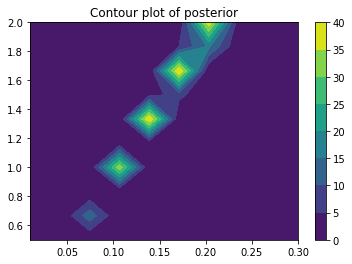

In [6]:
xlist = np.linspace(0.01, 0.3, 10)
ylist = np.linspace(0.5, 2, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = [[normalized_posterior(x, y) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute marginal distributions

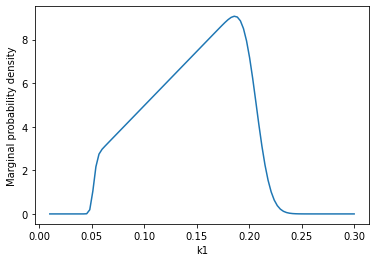

In [7]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.5, 2)[0]

thetas = np.linspace(0.01, 0.3, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_x(theta))

plt.plot(thetas, results)
plt.xlabel("k1")
plt.ylabel("Marginal probability density")
plt.savefig(my_path + '/prod_degr_margin_dist_x.pdf')
# plt.show()

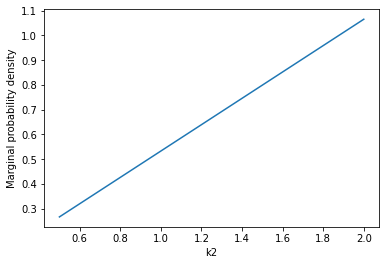

In [8]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.3)[0]

thetas = np.linspace(0.5, 2, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_y(theta))

plt.plot(thetas, results)
plt.xlabel("k2")
plt.ylabel("Marginal probability density")
plt.savefig(my_path + '/prod_degr_margin_dist_y.pdf')
# plt.show()

# Rejection ABC

In [38]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [9, 8, 7, 6]
resulting_kl = []

np.random.seed(1)
for error in error_thresholds:
    inter_kl = []
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior)
        # set threshold
        abc.sampler().set_threshold(error)
        # set target number of samples
        abc.set_n_samples(500)
        # log to screen
        abc.set_log_to_screen(True)
        print('Running...')
        samples  = abc.run()
        print('Done')

        samples_flat = np.array([item for sublist in samples for item in sublist])

        # computing the KDE and KL functions for x

        def marginal_distribution_x(x):
            partial_lam = lambda y : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0.5, 2)[0]

        def kl_func_x(y, kde_skl):
            part = marginal_distribution_x(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_x(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_x(y, kde_skl)
            return integrate.quad(fun, 0.013, 0.3)

        saved_x = kl_div_x(np.array(samples)[:, 0], 0.0033 * error)[0]

        # computing the KDE and KL functions for x
        def marginal_distribution_y(y):
            partial_lam = lambda x : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0, 0.3)[0]

        def kl_func_y(y, kde_skl):
            part = marginal_distribution_y(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_y(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_y(y, kde_skl)
            return integrate.quad(fun, 0.5, 2)

        saved_y = kl_div_y(np.array(samples[:, 1]), error * 0.013)[0]
        saved = saved_x + saved_y
        inter_kl.append(saved)

        print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))
    resulting_kl.append(inter_kl)

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.1
2     2      1                0:00.2
3     3      1                0:00.2
20    24     0.833333333      0:01.7
40    50     0.8              0:03.3
60    79     0.759493671      0:04.8
80    105    0.761904762      0:05.7
100   130    0.769230769      0:06.6
120   157    0.76433121       0:07.6
140   184    0.760869565      0:08.6
160   213    0.751173709      0:09.8
180   245    0.734693877551   0:11.1
200   272    0.735294118      0:12.1
220   301    0.73089701       0:13.3
240   325    0.738461538      0:14.2
260   347    0.749279539      0:14.9
280   373    0.750670241      0:15.9
300   401    0.748129676      0:17.0
320   427    0.74941452       0:17.9
340   457    0.743982495      0:19.2
360   481    0.748440748      0:20.3
380   513    0.740740741      0:21.6
400   540    0.740740741      0:22.6
420   568    0.73943662       0:23.6
440   594    0.7

No handles with labels found to put in legend.


[[0.6997027051615712, 0.7146013054795824, 0.6766880769101251, 0.6767225321670234, 0.6966599065310158], [0.6411393099048837, 0.5931310650625194, 0.5909390425984373, 0.6288520708060714, 0.5891021576654631], [0.49280726236476546, 0.4294088495722491, 0.5044787072362984, 0.5297787951162817, 0.5404582762923391], [0.44331750124049596, 0.3267745652000694, 0.36559176433567453, 0.38584028233572165, 0.39586794247632684]]


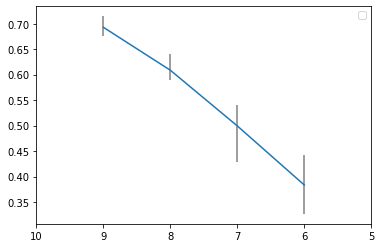

In [39]:
res_rej_abc = resulting_kl

print(resulting_kl)

resulting_kl = np.array(resulting_kl)

mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(10, 5)

plt.legend()
plt.show()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')
plt.show()

# Modified PMC

In [43]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [9, 8, 7, 6]
resulting_kl = []

for error in error_thresholds:
    inter_kl = []
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([1.5 * error, 1.3 * error, error]))

        # produce intermediate distributions of size 200
        abc.sampler().set_intermediate_size(100)

        # set target number of samples
        abc.set_n_samples(700)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        samples_flat = samples

        # computing the KDE and KL functions for x

        def marginal_distribution_x(x):
            partial_lam = lambda y : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0.5, 2)[0]

        def kl_func_x(y, kde_skl):
            part = marginal_distribution_x(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_x(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_x(y, kde_skl)
            return integrate.quad(fun, 0.013, 0.3)

        saved_x = kl_div_x(samples_flat[200:, 0], 0.0033 * error)[0]

        # computing the KDE and KL functions for x
        def marginal_distribution_y(y):
            partial_lam = lambda x : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0, 0.3)[0]

        def kl_func_y(y, kde_skl):
            part = marginal_distribution_y(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_y(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_y(y, kde_skl)
            return integrate.quad(fun, 0.5, 2)

        saved_y = kl_div_y(samples_flat[200:, 1], error * 0.013)[0]
        saved = saved_x + saved_y
        inter_kl.append(saved)

        print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))
    resulting_kl.append(inter_kl)

Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=13.5
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.1
2     2      1                0:00.1
3     3      1                0:00.2
20    25     0.8              0:01.4
40    47     0.85106383       0:02.2
60    68     0.882352941      0:03.0
80    92     0.869565217      0:04.1
Starting t=1, with threshold=11.700000000000001
100   114    0.877192982      0:04.9
120   136    0.882352941      0:05.7
140   158    0.886075949      0:06.5
160   180    0.888888889      0:07.5
180   200    0.9              0:08.5
Starting t=2, with threshold=9.0
200   221    0.904977376      0:09.5
220   241    0.912863071      0:10.3
240   263    0.912547529      0:11.2
260   284    0.915492958      0:11.9
280   306    0.91503268       0:12.7
300   328    0.914634146      0:13.5
320   353    0.906515581      0:14.4
340   375    0.906666667      0:15.3
360   396    0.909090909      0:16.0
380   419    0.906921241     

No handles with labels found to put in legend.


[[0.6244732296662584, 0.7603934413137794, 0.6581481144532635, 0.6332945148789612, 0.7984554592627223], [0.6469410745503323, 0.6058792688027375, 0.48257785873750747, 0.737825111553424, 0.6425827054970452], [0.4114017085798402, 0.5465029377633099, 0.49737848388762257, 0.42923671458616636, 0.48032479127236705], [0.5200758625869404, 0.4012942305677072, 0.42411389505838, 0.5091899943917457, 0.4287786439850808]]


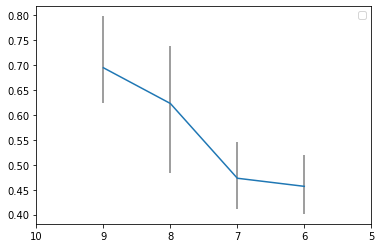

In [44]:
res_fake_pmc = resulting_kl

print(resulting_kl)

resulting_kl = np.array(resulting_kl)

mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(10, 5)

plt.legend()
plt.show()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')


# ABC PMC

In [45]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [9, 8, 7, 6]
resulting_kl = []

for error in error_thresholds:
    inter_kl = []
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([1.5 * error, 1.3 * error, error]))

        # produce intermediate distributions of size 500
        abc.sampler().set_intermediate_size(500)

        # set target number of samples
        abc.set_n_samples(1500)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        samples_flat = samples

        # computing the KDE and KL functions for x

        def marginal_distribution_x(x):
            partial_lam = lambda y : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0.5, 2)[0]

        def kl_func_x(y, kde_skl):
            part = marginal_distribution_x(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_x(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_x(y, kde_skl)
            return integrate.quad(fun, 0.013, 0.3)

        saved_x = kl_div_x(samples_flat[1000:, 0], 0.0033 * error)[0]

        # computing the KDE and KL functions for x
        def marginal_distribution_y(y):
            partial_lam = lambda x : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0, 0.3)[0]

        def kl_func_y(y, kde_skl):
            part = marginal_distribution_y(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_y(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_y(y, kde_skl)
            return integrate.quad(fun, 0.5, 2)

        saved_y = kl_div_y(samples_flat[1000:, 1], error * 0.013)[0]
        saved = saved_x + saved_y
        inter_kl.append(saved)

        print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))
    resulting_kl.append(inter_kl)

Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=13.5
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.1
2     2      1                0:00.2
3     3      1                0:00.2
20    26     0.769230769      0:01.7
40    49     0.816326531      0:02.8
60    72     0.833333333      0:03.7
80    98     0.816326531      0:04.6
100   127    0.787401575      0:05.9
120   152    0.789473684      0:06.8
140   178    0.786516854      0:08.0
160   201    0.7960199        0:08.8
180   222    0.810810811      0:09.7
200   245    0.816326531      0:10.5
220   273    0.805860806      0:11.6
240   303    0.792079208      0:12.8
260   327    0.795107034      0:13.8
280   351    0.797720798      0:14.8
300   374    0.802139037      0:15.8
320   402    0.7960199        0:16.8
340   435    0.781609195      0:18.1
360   460    0.782608696      0:19.5
380   488    0.778688525      0:20.6
400   511    0.782778865      0:21.5
420   534    0.786516854      0:22.5

No handles with labels found to put in legend.


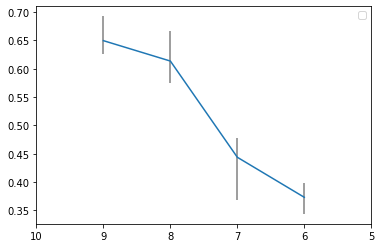

In [46]:
res_true_pmc = resulting_kl

resulting_kl = np.array(resulting_kl)

mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(10, 5)

plt.legend()
plt.show()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')

# All errors

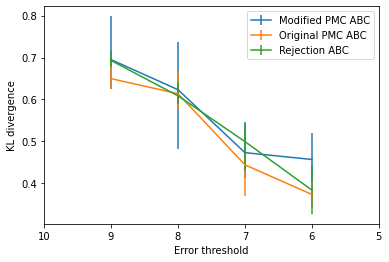

In [50]:
res_fake_pmc = np.array(res_fake_pmc)
res_true_pmc = np.array(res_true_pmc)
res_rej_abc = np.array(res_rej_abc)

mins_fake_pmc_kl = res_fake_pmc.min(1)
maxes_fake_pmc_kl = res_fake_pmc.max(1)
means_fake_pmc_kl = res_fake_pmc.mean(1)

mins_true_pmc_kl = res_true_pmc.min(1)
maxes_true_pmc_kl = res_true_pmc.max(1)
means_true_pmc_kl = res_true_pmc.mean(1)

mins_abc_rej_kl = res_rej_abc.min(1)
maxes_abc_rej_kl = res_rej_abc.max(1)
means_abc_rej_kl = res_rej_abc.mean(1)

plt.errorbar(error_thresholds, means_fake_pmc_kl, [means_fake_pmc_kl - mins_fake_pmc_kl, maxes_fake_pmc_kl - means_fake_pmc_kl], label='Modified PMC ABC')
plt.errorbar(error_thresholds, means_true_pmc_kl, [means_true_pmc_kl - mins_true_pmc_kl, maxes_true_pmc_kl - means_true_pmc_kl], label='Original PMC ABC')
plt.errorbar(error_thresholds, means_abc_rej_kl, [means_abc_rej_kl - mins_abc_rej_kl, maxes_abc_rej_kl - means_abc_rej_kl], label='Rejection ABC')
plt.xlim(10, 5)
plt.legend()
# plt.show()


# print(res_fake_pmc)

# ax.plot(error_thresholds, res_fake_pmc, label='Modified PMC ABC')
# ax.plot(error_thresholds, res_true_pmc, label='Original PMC ABC')
# ax.plot(error_thresholds, res_rej_abc, label='Rejection ABC')
# ax.set_xlim(10, 5)
# ax.grid(True)
# ax.legend()
# plt.show()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.xlabel("Error threshold")
plt.ylabel("KL divergence")

plt.savefig(my_path + '/production_degradation_errors_all.pdf')

# Adaptive PMC ABC

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [0.6, 0.5, 0.4, 0.3]
resulting_kl = []

for error in error_thresholds:
    inter_kl = []
    for i in range(5):
        print("trying error="+str(error))
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

        # set threshold
        abc.sampler().set_N_l(150)

        # set p_acc_min
        abc.sampler().set_p_acc_min(error)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        print('Running...')
        samples  = abc.run()
        print('Done')

        samples_flat = samples

        # computing the KDE and KL functions for x

        def marginal_distribution_x(x):
            partial_lam = lambda y : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0.5, 2)[0]

        def kl_func_x(y, kde_skl):
            part = marginal_distribution_x(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_x(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_x(y, kde_skl)
            return integrate.quad(fun, 0.013, 0.3)

        saved_x = kl_div_x(samples_flat[:, 0], error * 0.07)[0]

        # computing the KDE and KL functions for x
        def marginal_distribution_y(y):
            partial_lam = lambda x : normalized_posterior(x, y)
            return integrate.quad(partial_lam, 0, 0.3)[0]

        def kl_func_y(y, kde_skl):
            part = marginal_distribution_y(y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                print("something with = "+str(y))
                print("")
                return -np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div_y(x, bandwidth, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func_y(y, kde_skl)
            return integrate.quad(fun, 0.5, 2)

        saved_y = kl_div_y(samples_flat[:, 1], error / 3)[0]
        saved = saved_x + saved_y
        inter_kl.append(saved)

        print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))
    resulting_kl.append(inter_kl)

trying error=0.6
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.1739378  1.36064895]
resulting var=[[0.00872226 0.04697379]
 [0.04697379 0.34398837]]
epsilon=4.696807426326951
w_mean=[0.16779423 1.47079507]
resulting var=[[0.00565645 0.03804576]
 [0.03804576 0.33740296]]
Iter. Eval. Acceptance rate Time m:s
1     3      166.6666666667   1:21.4
cnt_sampled=1200
Halting: target number of samples (500) reached.
Done
saved_x=0.3153092999030587, saved_y=0.14226483826213207
trying error=0.6
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.16547028 1.38636028]
resulting var=[[0.00717644 0.04097696]
 [0.04097696 0.34949113]]
Iter. Eval. Acceptance rate Time m:s
1     2      250              0:42.3
cnt_sampled=850
Halting: target number of samples (500) reached.
Done
saved_x=0.38206616178974206, saved_y=0.1461879694038423
trying error=0.6
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.17108398 1.39365196]
resulting var=[[0

In [10]:
res_adaptive = resulting_kl

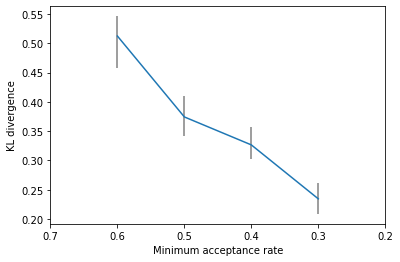

In [13]:
resulting_kl = np.array(resulting_kl)

mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(0.7, 0.2)

# plt.legend()
# plt.show()

# ax.plot(error_thresholds, res_true_pmc, label='Original PMC ABC')
# ax.plot(error_thresholds, res_rej_abc, label='Rejection ABC')


import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.xlabel("Minimum acceptance rate")
plt.ylabel("KL divergence")
plt.savefig(my_path + '/production_degradation_errors_adaptive.pdf')

In [25]:
print(res_fake_pmc)

[[0.91269771 0.72027288 0.87755215 0.79224802 0.7167696 ]
 [0.83410061 0.81315085 0.66821163 0.74529651 0.80786673]
 [0.69480002 0.688582   0.64865837 0.67369686 0.70398093]
 [0.63040684 0.59393334 0.579185   0.63964907 0.67705782]]


In [26]:
print(res_true_pmc)

[[0.76972686 0.74845162 0.7288782  0.81272233 0.72505111]
 [0.76298297 0.69125619 0.71252717 0.74451029 0.68584691]
 [0.64638751 0.67308885 0.66331783 0.67403931 0.58761637]
 [0.57517588 0.58737834 0.53927101 0.57602678 0.62274245]]


In [27]:
print(res_rej_abc)

[[0.79340372 0.81440304 0.76213187 0.78828906 0.80180155]
 [0.74720146 0.72284114 0.74109486 0.7608119  0.75649779]
 [0.67432695 0.65455188 0.69776608 0.69469176 0.65855075]
 [0.60023909 0.610994   0.60837458 0.58259684 0.61570823]]


In [12]:
print(res_adaptive)

[[0.45757413816519077, 0.5282541311935843, 0.5459968755087168, 0.5279029430285624, 0.5013596673956243], [0.34156508171693445, 0.38383923220365634, 0.37127160486376737, 0.4105954282797092, 0.36401339525956333], [0.3569670270761246, 0.30294103735111316, 0.3206566644372475, 0.3325419177161221, 0.31977878391697745], [0.24205448585431322, 0.24927845351987665, 0.26210979268785095, 0.21068491301537104, 0.2088625989223726]]
